In [1]:
import warnings
warnings.filterwarnings('ignore')
#Data Manipulation and Treatment
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
#Plotting and Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#Scikit-Learn for Modeling
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
#Statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [18]:
df = yf.download('aapl', start='2010-01-01', end='2020-01-01')
df = df.resample('D').asfreq()
df = df.ffill()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515211,493729600.0
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800.0
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000.0
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200.0
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800.0


Text(0.5, 1.0, 'Apple Closing Price')

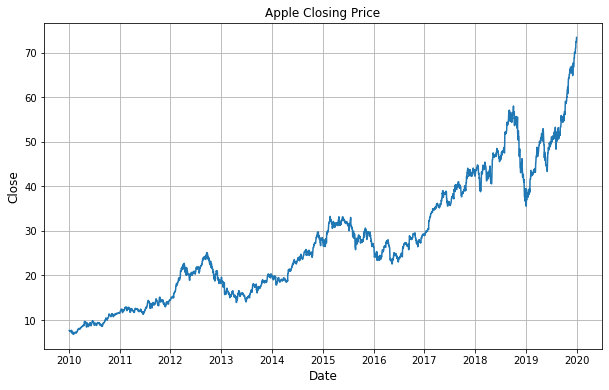

In [19]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df["Close"], label='Original')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.title('Apple Closing Price')

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

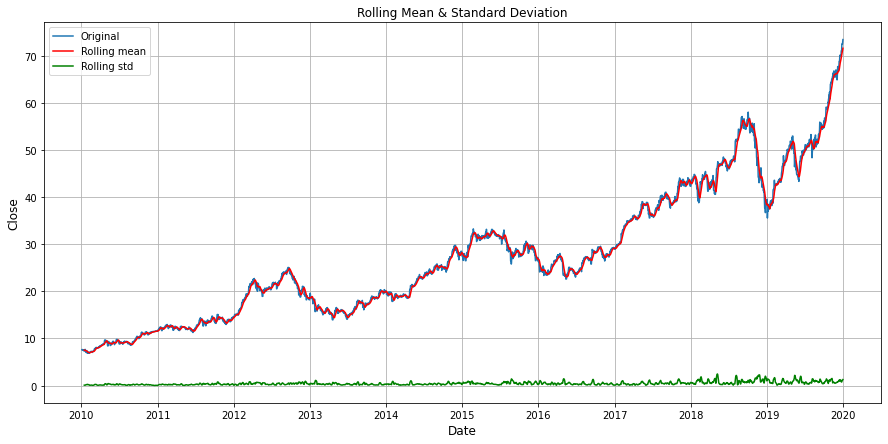

In [20]:
plt.figure(figsize=(15,7))
plt.plot(df["Close"], label='Original')
plt.plot(df["Close"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df["Close"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.title('Rolling Mean & Standard Deviation')

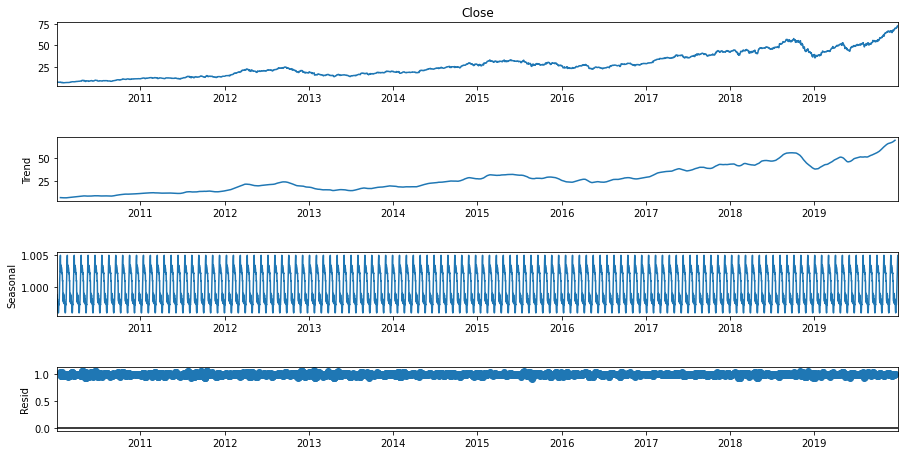

In [21]:
# Checking Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
    
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

In [22]:
#Running ADF Test
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    if dftest[1] > 0.05:
        print('Cannot reject the Null Hypothesis: Data not stationary.')
    else:
        print('Reject the Null Hypothesis: Data is stationary.')
ADF_test(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    0.929703
p-value                           0.993466
Lags Used                        30.000000
Number of Observations Used    3618.000000
Critical Value (1%)              -3.432159
Critical Value (5%)              -2.862339
Critical Value (10%)             -2.567195
dtype: float64
Cannot reject the Null Hypothesis: Data not stationary.


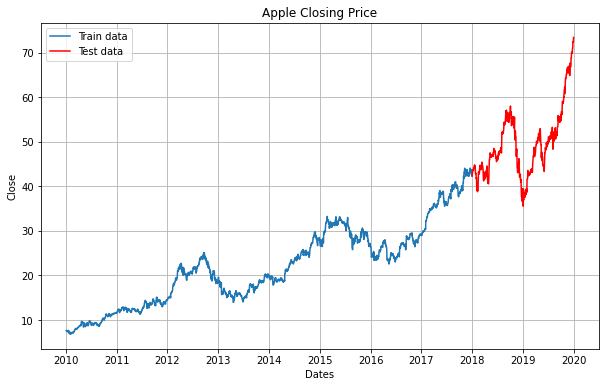

In [23]:
#split data into train and training set
df_train, df_test = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]
y_pred=df_test.copy()
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close')
plt.plot(df_train['Close'], label='Train data')
plt.plot(df_test['Close'], 'red', label='Test data')
plt.title('Apple Closing Price')
plt.legend()

Text(0.5, 1.0, 'First Order Differencing')

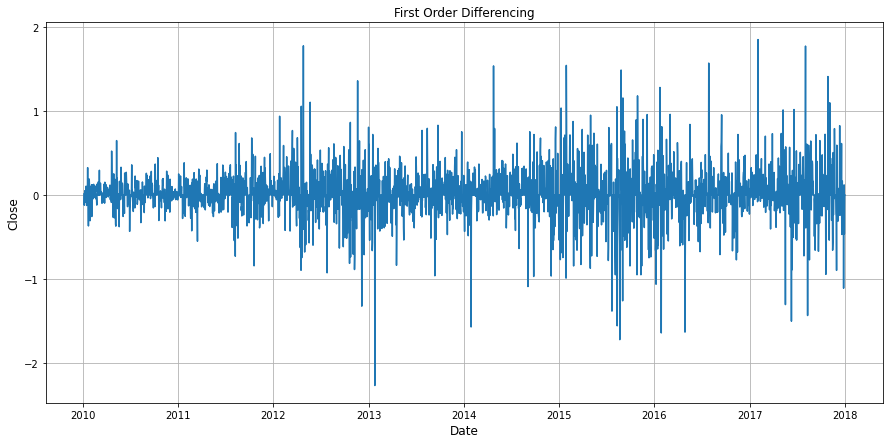

In [24]:
df_train_diff = df_train['Close'].diff().dropna()
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(df_train_diff, label='Original')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.title('First Order Differencing')

In [25]:
ADF_test(df_train_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -24.754714
p-value                           0.000000
Lags Used                         4.000000
Number of Observations Used    2913.000000
Critical Value (1%)              -3.432597
Critical Value (5%)              -2.862533
Critical Value (10%)             -2.567298
dtype: float64
Reject the Null Hypothesis: Data is stationary.


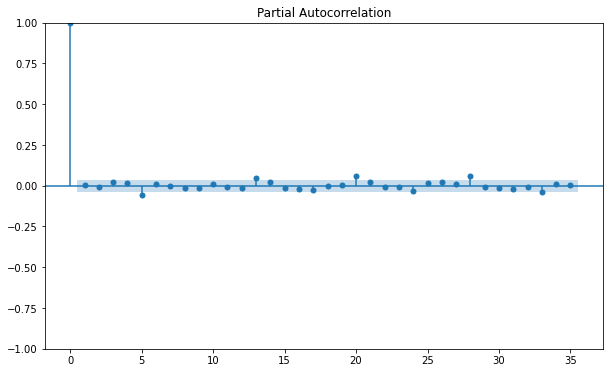

In [26]:
plt.rc("figure", figsize=(10,6))
pacf = plot_pacf(df_train_diff)

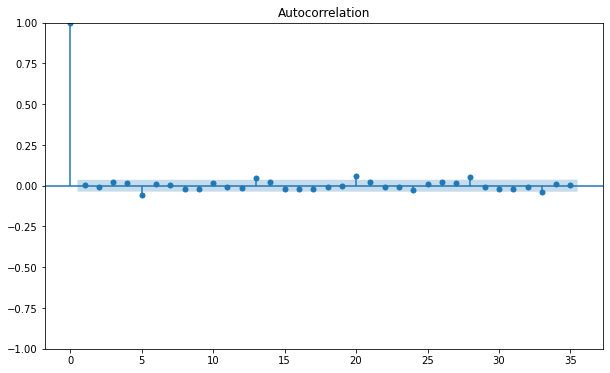

In [27]:
acf = plot_acf(df_train_diff)

In [28]:
model_arima= auto_arima(df_train['Close'],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=30,max_q=30,
              suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(df_train['Close'])


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1022.487, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1024.462, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1026.317, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1026.714, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1027.500, Time=0.51 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1021.288, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1024.463, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1026.463, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1028.439, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1028.499, Time=1.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1025.087, Time=1.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1026.318, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1028.129, Time=1.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1017.769, Time=1.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1018.501, Time=2.10 sec
 ARIMA(3,1

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [29]:
prediction_arima=model_arima.predict(len(df_test))
y_pred["ARIMA Model Prediction"]=prediction_arima.dropna()

mse_arima= mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
mape_arima=mean_absolute_percentage_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
print("Mean Square Error ARIMA: ",mse_arima)
print("Mean Absoulute Percentage Error ARIMA: ",mae_arima)


Mean Square Error ARIMA:  48.072328826429015
Mean Absoulute Percentage Error ARIMA:  0.42482809434673563


Text(0.5, 1.0, 'ARIMA(2,1,2) Model Results')

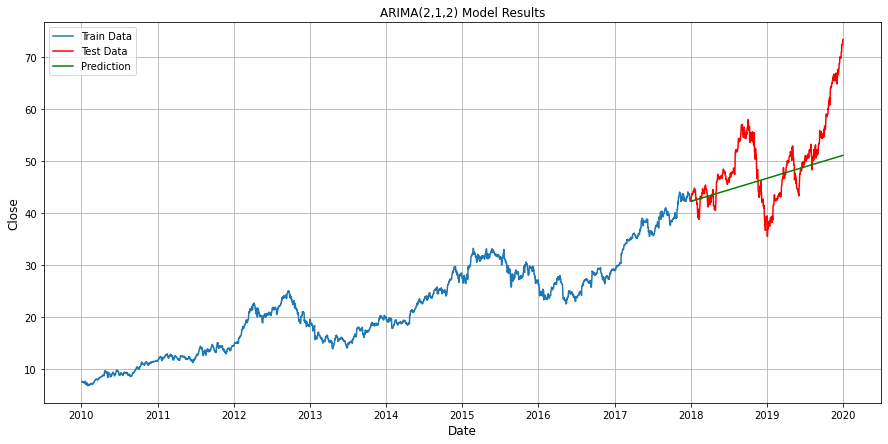

In [30]:
plt.figure(figsize=(15,7))
plt.plot(df_train["Close"], label='Train Data')
plt.plot(df_test["Close"], color='red', label='Test Data')
plt.plot(y_pred["ARIMA Model Prediction"], color='green', label='Prediction')
plt.grid(True)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(loc='best')
plt.title('ARIMA(2,1,2) Model Results')